In [7]:
import pandas as pd
import numpy as np
from random import random
from DGP.DGP import dgp2, plot_hists
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

### Import Causal Forest packages:

In [6]:
from sklearn.tree import DecisionTreeRegressor
from econml.dml import CausalForestDML as CausalForest
from sklearn.linear_model import LassoCV

<h2><center>Generating data to estimate treatment effect: </center></h2>
$$
Y_i = -1.5D +  3D \cdot \mathcal{I}_{\{x_1 \geq 0\}} + x_2 + x_3 + x_4 + e_i
$$
<h3><center> </center></h3>
$$
\mathcal{I}_{\{x_1 \geq 0\}}=1: \text{if  } x_1 >= 0, 
$$


<h2><center>Treatment effect: </center></h2>
$$\tau_i(x) = -1.5 + 3 \cdot \mathcal{I}_{\{x_1 \geq 0\}}
$$

<h2><center><img src="other/t1.png"></center></h2>

In [3]:
n = 3000 #sample size
var_e = 0.01 #variance of error term
X, y, d = dgp2(n, var_e) #function to generate the sample

<Figure size 1080x1080 with 0 Axes>

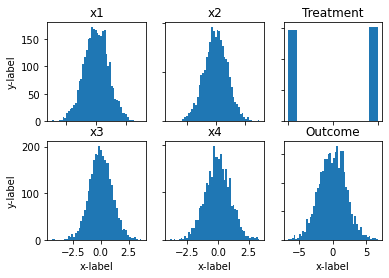

In [4]:
plot_hists(X,y,d)

In [4]:
x1 = (X[:,0]).reshape(-1,1)
x2 = (X[:,1]).reshape(-1,1)
x3 = (X[:,2]).reshape(-1,1)
x4 = (X[:,3]).reshape(-1,1)
t1pos = np.mean(y[(x1>= 0) & (d == 1)]) - np.mean(y[(x1>= 0) & (d == 0)])
t1neg = np.mean(y[(x1< 0) & (d == 1)]) - np.mean(y[(x1< 0) & (d == 0)])
t2pos = np.mean(y[(x2>= 0) & (d == 1)]) - np.mean(y[(x2>= 0) & (d == 0)])
t2neg = np.mean(y[(x2< 0) & (d == 1)]) - np.mean(y[(x2< 0) & (d == 0)])
t3pos = np.mean(y[(x3>= 0) & (d == 1)]) - np.mean(y[(x3>= 0) & (d == 0)])
t3neg = np.mean(y[(x3< 0) & (d == 1)]) - np.mean(y[(x3< 0) & (d == 0)])
t4pos = np.mean(y[(x4>= 0) & (d == 1)]) - np.mean(y[(x4>= 0) & (d == 0)])
t4neg = np.mean(y[(x4< 0) & (d == 1)]) - np.mean(y[(x4< 0) & (d == 0)])
x_axis = ['x4<0', 'x3<0', 'x2<0', 'x1<0', 'x1>=0', 'x2>=0', 'x3>=0', 'x4>=0']
tau = [t4neg, t3neg, t2neg, t1neg, t1pos, t2pos, t3pos, t4pos]

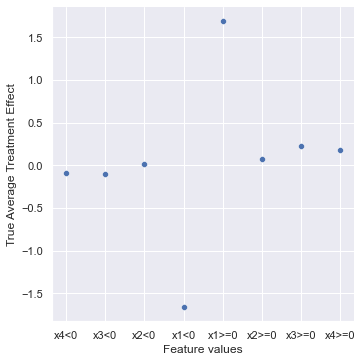

In [5]:
sns.set_theme()
g = sns.relplot(x=x_axis, y=tau)
g.set_axis_labels("Feature values", "True Average Treatment Effect")

In [6]:
df = pd.DataFrame(np.concatenate((np.concatenate((y,X),axis =1),d), axis = 1), columns = ['y', 'x1', 'x2', 'x3', 'x4', 'd'])
# divide data into traning and test
train, test = train_test_split(df, test_size=0.2)
#define features, outcome variable, treatment 
regressors = ['x1', 'x2', 'x3', 'x4']
Y = train['y']
T = train['d']
X = train[regressors]
W = None
X_test = test[regressors]

In [7]:
# Estimate causal forest
estimator = CausalForest(criterion='het', 
                                n_estimators=10000,       
                                min_samples_leaf=10, 
                                max_depth=3,
                                honest=True,
                                inference=True,
                                cv=10,
                                model_t=LassoCV(), 
                                model_y=LassoCV(),
                                )

In [8]:
# fit the CF
estimator.fit(Y,T,X=X, W=W)

In [9]:
# Find estimated treatment effects on training and test samples
effects_train = estimator.effect(X)
effects_test = estimator.effect(X_test)

In [10]:
x1_tr = np.array(train['x1']).reshape(-1,1)
x1_te = np.array(test['x1']).reshape(-1,1)
x2_tr = np.array(train['x2']).reshape(-1,1)
x2_te = np.array(test['x2']).reshape(-1,1)
x3_tr = np.array(train['x3']).reshape(-1,1)
x3_te = np.array(test['x3']).reshape(-1,1)
x4_tr = np.array(train['x4']).reshape(-1,1)
x4_te = np.array(test['x4']).reshape(-1,1)
effects_test =effects_test.reshape(-1,1) 
effects_train = effects_train.reshape(-1,1) 

In [11]:
pred_tr = [np.mean(effects_train[(x4_tr< 0)]),
np.mean(effects_train[(x3_tr< 0)]),
np.mean(effects_train[(x2_tr< 0)]),
np.mean(effects_train[(x1_tr< 0)]),
np.mean(effects_train[(x1_tr>= 0)]),
np.mean(effects_train[(x2_tr>= 0)]),
np.mean(effects_train[(x3_tr>= 0)]),
np.mean(effects_train[(x4_tr>= 0)])]
pred_te = [np.mean(effects_test[(x4_te< 0)]),
np.mean(effects_test[(x3_te< 0)]),
np.mean(effects_test[(x2_te< 0)]),
np.mean(effects_test[(x1_te< 0)]),
np.mean(effects_test[(x1_te>= 0)]),
np.mean(effects_test[(x2_te>= 0)]),
np.mean(effects_test[(x3_te>= 0)]),
np.mean(effects_test[(x4_te>= 0)])]

In [12]:
results = pd.DataFrame(list(zip(x_axis, tau, pred_tr, pred_te)), columns = ['Feature Condition', 'True Treatment Effect','Estimated TE (training)', 'Estimated TE (test)'])
results

,Feature Condition,True Treatment Effect,Estimated TE (training),Estimated TE (test)
0,x4<0,-0.093856,-0.025719,-0.103333
1,x3<0,-0.108516,0.006684,-0.091456
2,x2<0,0.017506,0.044707,0.046705
3,x1<0,-1.661231,-1.484488,-1.490528
4,x1>=0,1.689700,1.485996,1.484483
5,x2>=0,0.075235,-0.028104,-0.100372
6,x3>=0,0.225001,0.009651,0.035405
7,x4>=0,0.179339,0.041686,0.043306


 99%|===================| 2366/2400 [00:17<00:00]        

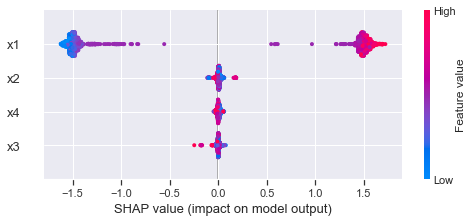

In [13]:
# code adapted from https://github.com/microsoft/EconML
import shap
from econml.dml import CausalForestDML
# fit causal forest with default parameters 
causal_forest = CausalForestDML()
causal_forest.fit(Y, T, X=X, W=W)
# calculate shap values of causal forest model 
shap_values = causal_forest.shap_values(X)
# plot shap values 
shap.summary_plot(shap_values['Y0']['T0'])